# Lesson 7 Intermediate Python for Data Analytics (Finance Performance and Fraudulent Detection)
# Introduction


## In this lesson we are going to try to scrape financial data:
* Income statement
* Balance sheet
* Cashflows

## Objective
* To use twippy (Python Library linked with Twitter) to load data from Twitter
* Setting up Twitter Developer account linked to profile
* Initialize Connections and Extracting the presidential election tweets
* To explore Presidential Election Trump vs Hillary from Twitter data
    * Viewing the data
    * Search Term Analysis
    * Exploring Twitter Trends
* Sentimental Analysis
    * Generating Sentimental Analysis
    * Plotting out Sentimental Analysis
    * How about the news media. How often do they mention the election candidates?
* Topic Analysis
    * Generating Topic with LDA
    * Plotting out Topic Analysis
* Challenges:
    * Analysing fake news
    * Analysing geographic locations sentiments given charts
    * Applying these techniques for companies, commodities, and stocks
* Next lesson:
    * Lesson 6 Basic Python for Data Analytics (Optimization Model for Operations Management)

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


days_per_year = 365.24

start = datetime.datetime.now()-datetime.timedelta(days=(5*days_per_year))
end = datetime.datetime.now()

companies = ['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT']

# To pull individual stock
# df = web.DataReader("AAPL", 'google', start, end)
# df.tail()

# To pull group stocks
dfcomp = web.DataReader(companies,'google',
                               start=start, 
                               end=end)['Close']
dfcomp.tail()

,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2017-06-19,146.34,28.80,957.37,154.84,70.87
2017-06-20,145.01,28.13,950.63,154.95,69.91
2017-06-21,145.87,27.78,959.45,153.79,70.27
2017-06-22,145.63,27.55,957.09,154.40,70.26
2017-06-23,146.28,27.57,965.59,154.11,71.21


# Scraping Wikipedia SP500 Data Using Beautiful Soup

In [2]:
import bs4 as bs
import pickle
import requests

# This will keep tickers + gics industries & sub industries
def save_sp500_stocks_info():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    stocks_info=[]
    tickers = []
    gics_industries = []
    gics_sub_industries = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        gics_industry = row.findAll('td')[3].text
        gics_sub_industry = row.findAll('td')[4].text

        tickers.append(ticker.lower())
        gics_industries.append(gics_industry.lower())
        gics_sub_industries.append(gics_sub_industry.lower())
    
    stocks_info.append(tickers)
    stocks_info.append(gics_industries)
    stocks_info.append(gics_sub_industries)
    return stocks_info

stocks_info = save_sp500_stocks_info()
stocks_info_df = pd.DataFrame(stocks_info).T
stocks_info_df.columns=['tickers','gics_industry','gics_sub_industry']
stocks_info_df.set_index('tickers',inplace=True)

# Extract just the tickers list
tickers= stocks_info[0]

In [3]:
tickers[:5]

[u'mmm', u'abt', u'abbv', u'acn', u'atvi']

# Scraping Financial Data
Using Selenium to scrape 
http://www.nasdaq.com/symbol/aapl/financials?query=income-statement&data=quarterly

## Repeat the scraping for multiple websites

In [1]:
import pandas as pd
from numpy import nan
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options

In [2]:
## return nan values if elements not found, and convert the webelements to text
def get_elements(xpath,browser):
    ## find the elements
    elements = browser.find_elements_by_xpath(xpath)
    ## if any are missing, return all nan values
    if len(elements) != 4:
        return [nan] * 4
    ## otherwise, return just the text of the element 
    else:
        text = []
        for e in elements:
            text.append(e.text)
        return text

In [107]:
dollarlist = [u'total_revenue', u'gross_profit',u'net_income', u'total_assets', u'total_liabilities', u'total_equity','fixed_assets','goodwill','net_cash_flow'] 

ratiolist = [u'liq_current_ratio', u'liq_quick_ratio', u'liq_cash_ratio',
       u'prof_gross_margin', u'prof_operating_margin', u'prof_profit_margin']

In [128]:
import numpy as np
def clean_up(period,df):
    
#     Let the null be regarded as 0
    df.loc[:,dollarlist]=df.loc[:,dollarlist].fillna('$0')
# Do a regex setting to replace dollar sign
    df.loc[:,dollarlist] = df.loc[:,dollarlist].replace( '[\$,)]','', regex=True ).replace( '[(]','-',   regex=True ).astype(long)
    if period=='yearly':

#     Let the null be regarded as 0
        df.loc[:,ratiolist]=df.loc[:,ratiolist].fillna('0%')
# Do a regex setting to process percentage sign
        df.loc[:,ratiolist] = df.loc[:,ratiolist].apply(lambda x: x.str.replace('%','')).astype(np.float)/100
    return df

In [11]:
# Yearly

def scrapenasdaq(period,symbols,csv_path):
    
    chrome_options = Options()
    chrome_options.add_argument("--disable-extensions")

    ## launch the Chrome browser (this will generate a window)
    my_path = "chromedriver.exe"
    browser = webdriver.Chrome(executable_path=my_path,chrome_options=chrome_options)
    browser.maximize_window()
    df = pd.DataFrame()
    
    financials_xpath = "//tbody/tr/th[text() = '{}']/../td[contains(text(), '$')]"
    ratios_xpath = "//tbody/tr/th[text() = '{}']/../td[contains(text(), '%')]"

#     Create yearly scraping or quarterly scraping
    if period == 'yearly':
        url_form = "http://www.nasdaq.com/symbol/{}/financials?query={}" 
    else:
        url_form = "http://www.nasdaq.com/symbol/{}/financials?query={}&data=quarterly" 

    for i, symbol in enumerate(symbols):
        try:
            ## navigate to income statement quarterly page    
            url = url_form.format(symbol, "income-statement")
            browser.get(url)

            company_xpath = "//h1[contains(text(), 'Company Financials')]"
            company = WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.XPATH, company_xpath))).text
            
            period_endings=""
            quarters = ""
            quarter_endings = ""
            if period=='yearly':
                period_endings_xpath = "//thead/tr[th[1][text() = 'Period Ending:']]/th[position()>=3]"
                period_endings = get_elements(period_endings_xpath,browser)
            else:
                quarters_xpath = "//thead/tr[th[1][text() = 'Quarter:']]/th[position()>=3]"
                quarters = get_elements(quarters_xpath,browser)

                quarter_endings_xpath = "//thead/tr[th[1][text() = 'Quarter Ending:']]/th[position()>=3]"
                quarter_endings = get_elements(quarter_endings_xpath,browser)
                         
            total_revenue = get_elements(financials_xpath.format("Total Revenue"),browser)
            gross_profit = get_elements(financials_xpath.format("Gross Profit"),browser)
            net_income = get_elements(financials_xpath.format("Net Income"),browser)

            ## navigate to balance sheet quarterly page 
            url = url_form.format(symbol, "balance-sheet")
            browser.get(url)

            total_assets = get_elements(financials_xpath.format("Total Assets"),browser)
            total_liabilities = get_elements(financials_xpath.format("Total Liabilities"),browser)
            total_equity = get_elements(financials_xpath.format("Total Equity"),browser)
            fixed_assets = get_elements(financials_xpath.format("Fixed Assets"),browser)
            goodwill = get_elements(financials_xpath.format("Goodwill"),browser)


            ## navigate to cash flow quarterly page 
            url = url_form.format(symbol, "cash-flow")
            browser.get(url)

            net_cash_flow = get_elements(financials_xpath.format("Net Cash Flow"),browser)

            
            ## navigate to ratios page 
            if period=='yearly':
                url = url_form.format(symbol, "ratios")
                browser.get(url)

                liq_current_ratio = get_elements(ratios_xpath.format("Current Ratio"),browser)
                liq_quick_ratio = get_elements(ratios_xpath.format("Quick Ratio"),browser)
                liq_cash_ratio = get_elements(ratios_xpath.format("Cash Ratio"),browser)
                prof_gross_margin = get_elements(ratios_xpath.format("Gross Margin"),browser)
                prof_operating_margin = get_elements(ratios_xpath.format("Operating Margin"),browser)
                prof_profit_margin = get_elements(ratios_xpath.format("Profit Margin"),browser)
            
            ## fill the datarame with the scraped data, 4 rows per company
            for j in range(4):  
                row = i*4 + j
                df.loc[row, 'company'] = company
                df.loc[row, 'symbol'] = symbol
                
                if period == 'yearly':
                    df.loc[row, 'period_endings'] = period_endings[j]
                    df.loc[row, 'liq_current_ratio'] = liq_current_ratio[j]
                    df.loc[row, 'liq_quick_ratio'] = liq_quick_ratio[j]
                    df.loc[row, 'liq_cash_ratio'] = liq_cash_ratio[j]
                    df.loc[row, 'prof_gross_margin'] = prof_gross_margin[j]
                    df.loc[row, 'prof_operating_margin'] = prof_operating_margin[j]            
                    df.loc[row, 'prof_profit_margin'] = prof_profit_margin[j]
                else:
                    df.loc[row, 'quarter'] = quarters[j]
                    df.loc[row, 'quarter_ending'] = quarter_endings[j]
                
                df.loc[row, 'total_revenue'] = total_revenue[j]
                df.loc[row, 'gross_profit'] = gross_profit[j]
                df.loc[row, 'net_income'] = net_income[j]
                df.loc[row, 'total_assets'] = total_assets[j]
                df.loc[row, 'total_liabilities'] = total_liabilities[j]
                df.loc[row, 'total_equity'] = total_equity[j]
                df.loc[row, 'fixed_assets'] = fixed_assets[j]
                df.loc[row, 'goodwill'] = goodwill[j]
                
                df.loc[row, 'net_cash_flow'] = net_cash_flow[j]
        except IOError as e: 
            print("Symbol is not collected : ",symbol)
        except ValueError:
            print("Symbol is not collected : ",symbol)
        except:
            print("Symbol is not collected : ",symbol)
    
    browser.quit()
#     df = clean_up(period,df)
    
    ## create a csv file in our working directory with our scraped data
    df.to_csv(csv_path, index=False)
    
    return df

In [24]:
# 200 tickers = 3 hours 13 minutes
%%time
tickersused = tickers[:200]
# tickersused = ['msft','goog','mmm']
scrapenasdaq('yearly',tickersused,'output.csv')

('Symbol is not collected : ', u'acn')
('Symbol is not collected : ', u'aes')
('Symbol is not collected : ', u'aet')
('Symbol is not collected : ', u'a')
('Symbol is not collected : ', u'agn')
('Symbol is not collected : ', u'googl')
('Symbol is not collected : ', u'goog')
('Symbol is not collected : ', u'adp')
('Symbol is not collected : ', u'brk-b')
('Symbol is not collected : ', u'blk')
('Symbol is not collected : ', u'bf-b')
('Symbol is not collected : ', u'ca')
('Symbol is not collected : ', u'cbs')
('Symbol is not collected : ', u'ctxs')
('Symbol is not collected : ', u'coh')
('Symbol is not collected : ', u'cmcsa')
('Symbol is not collected : ', u'cop')
('Symbol is not collected : ', u'dow')
('Symbol is not collected : ', u'dte')
('Symbol is not collected : ', u'esrx')
('Symbol is not collected : ', u'fitb')
Wall time: 3h 13min 30s


### Reading output csv

In [187]:
financedf = pd.read_csv('200stockdata.csv')
financedf.set_index('symbol',inplace=True)
financedf = clean_up('yearly',financedf)
financedf[dollarlist]=financedf[dollarlist].astype('int64')
financedf[ratiolist]=financedf[ratiolist].astype('float')

# Getting Market data

In [26]:
import datetime
import pandas_datareader.data as web


start = datetime.datetime(2017, 1, 1)
end = datetime.datetime.now()

closingpricedf = web.DataReader(tickersused,'yahoo',
                               start=start, 
                               end=end)['Adj Close']
volumedf = web.DataReader(tickersused,'yahoo',
                               start=start, 
                               end=end)['Volume']
marketcapdf = closingpricedf*volumedf

In [74]:
marketdf = pd.DataFrame()
marketdf['closing_price'] = closingpricedf.reset_index().drop('Date',axis=1).tail(1).T.iloc[:,0].astype('int')
marketdf['volume'] = volumedf.reset_index().drop('Date',axis=1).tail(1).T.iloc[:,0].astype('int')
marketdf['market_cap'] = marketcapdf.reset_index().drop('Date',axis=1).tail(1).T.iloc[:,0].astype('int')

# Generating Financial Ratios data

A ratio analysis is a quantitative analysis of information contained in a company’s financial statements. Ratio analysis is based on line items in financial statements like the balance sheet, income statement and cash flow statement; the ratios of one item – or a combination of items - to another item or combination are then calculated. Ratio analysis is used to evaluate various aspects of a company’s operating and financial performance such as its efficiency, liquidity, profitability and solvency.

Read more: Ratio Analysis Definition | Investopedia http://www.investopedia.com/terms/r/ratioanalysis.asp#ixzz4ZzYSyt15 
Follow us: Investopedia on Facebook 

http://www.investorguide.com/article/13690/list-of-important-financial-ratios-for-stock-analysis/
http://www.va-interactive.com/inbusiness/editorial/finance/ibt/ratio_analysis.html

•	Price to liquidation Value  
        Amount that the shareholders will get if it is liquidated
        (Current Asset – Total liabilities) / Outstanding shares
        
•	Price to tangible Book Value  
        Total assets – Good will – Tangible assets – total liabilities
        
        
•	Market cap
        Outstanding shares/ Shareprice
        
•	EV (enterprise Value) 
        (Market cap +debt -cash )/EBIT (Earnings before interest and taxes  Earnings can be manipulated 
        
•	EV (Enterprise Value) /FCF  (Free Cash Flow) Net cash flow Operating- Net Cash Flow investing


In [222]:
# Putting in market information from marketdf
financedf['market_cap'] = marketdf['market_cap']
financedf['closing_price'] = marketdf['closing_price']
financedf['volume'] = marketdf['volume']

# Putting in industries from sp 500 list on wikipedia
financedf['gics_industry'] = stocks_info_df['gics_industry']
financedf['gics_sub_industry'] = stocks_info_df['gics_sub_industry']


In [223]:
financedf.columns

Index([u'company', u'period_endings', u'liq_current_ratio', u'liq_quick_ratio',
       u'liq_cash_ratio', u'prof_gross_margin', u'prof_operating_margin',
       u'prof_profit_margin', u'total_revenue', u'gross_profit', u'net_income',
       u'total_assets', u'total_liabilities', u'total_equity', u'fixed_assets',
       u'goodwill', u'net_cash_flow', u'market_cap', u'closing_price',
       u'volume', u'gics_industry', u'gics_sub_industry'],
      dtype='object')

In [224]:
# Add on the ratios 

financedf['price_to_tangible_book_values'] = financedf.total_assets-financedf.goodwill-financedf.fixed_assets-financedf.total_liabilities

In [225]:
financedf.head()

,company,period_endings,liq_current_ratio,liq_quick_ratio,liq_cash_ratio,prof_gross_margin,prof_operating_margin,prof_profit_margin,total_revenue,gross_profit,...,total_equity,fixed_assets,goodwill,net_cash_flow,market_cap,closing_price,volume,gics_industry,gics_sub_industry,price_to_tangible_book_values
symbol,,,,,,,,,,,,,,,,,,,,,
mmm,MMM Company Financials,12/31/2016,1.89,1.34,0.43,0.50,0.24,0.17,30109000,15069000,...,10298000,8516000,9166000,600000,330733041,191,1728600,industrials,industrial conglomerates,-7384000
mmm,MMM Company Financials,12/31/2015,1.54,1.05,0.27,0.49,0.23,0.16,30274000,14891000,...,11429000,8515000,9249000,-99000,330733041,191,1728600,industrials,industrial conglomerates,-6335000
mmm,MMM Company Financials,12/31/2014,2.06,1.44,0.56,0.48,0.22,0.16,31821000,15374000,...,13109000,8489000,7050000,-684000,330733041,191,1728600,industrials,industrial conglomerates,-2430000
mmm,MMM Company Financials,12/31/2013,1.70,1.18,0.45,0.48,0.22,0.15,30871000,14765000,...,17502000,8652000,7345000,-302000,330733041,191,1728600,industrials,industrial conglomerates,1505000
abt,ABT Company Financials,12/31/2016,4.02,3.65,2.82,0.57,0.15,0.07,20853000,11829000,...,20538000,8458000,7683000,13619000,316918642,44,7136200,health care,health care equipment,4397000


# Filtering and Ranking Companies Together

We will filter and rank the companies based on the critical ratios, 

In [226]:
financedfaverage.columns

Index([u'liq_current_ratio', u'liq_quick_ratio', u'liq_cash_ratio',
       u'prof_gross_margin', u'prof_operating_margin', u'prof_profit_margin'],
      dtype='object')

In [229]:
# current ratio and quick ratio is above 1
# Debt ratio is at the lower percentage
# High gross/net profit margin. 
# High ROE and ROA
financedfaverage = financedf.loc[:,ratiolist].groupby(financedf.index).mean()
criteria_liquidity = (financedfaverage.liq_quick_ratio>=1) & (financedfaverage.liq_current_ratio>=1)


financedfaverage['gics_industry'] = stocks_info_df['gics_industry']
financedfaverage['gics_sub_industry'] = stocks_info_df['gics_sub_industry']

financedfaverage.loc[criteria_liquidity,:].sort_values('prof_profit_margin',ascending=False).head(5)

,liq_current_ratio,liq_quick_ratio,liq_cash_ratio,prof_gross_margin,prof_operating_margin,prof_profit_margin,gics_industry,gics_sub_industry
symbol,,,,,,,,
coty,2.9950,2.3450,1.5650,0.4875,0.9575,1.2150,consumer staples,personal products
apa,1.7250,1.4875,0.5425,0.7400,0.6950,0.6650,energy,oil & gas exploration & production
xec,1.5950,1.4900,0.9200,0.7100,0.9625,0.6225,energy,oil & gas exploration & production
dvn,1.2375,1.2375,0.6525,0.8450,0.5250,0.3625,energy,oil & gas exploration & production
ebay,2.2875,2.2875,1.4325,0.8000,0.2750,0.3425,information technology,internet software & services


In [239]:
financedfaverage.prof_profit_margin.min()

0.0

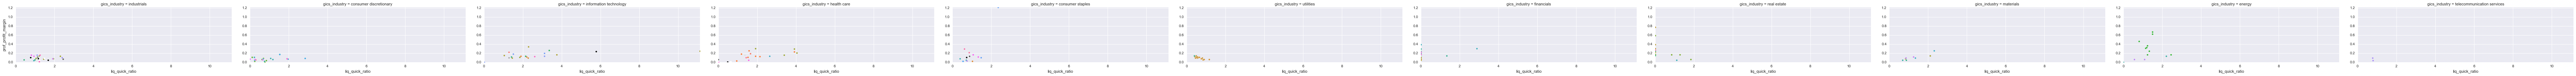

In [246]:
# See patterns with the liq_current_ratio and profitability group by industry

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

g = sns.FacetGrid(financedfaverage, col="gics_industry",  hue="gics_sub_industry",size=3,aspect=3, sharex=False, sharey=False)
g = g.map(plt.scatter, "liq_quick_ratio", "prof_profit_margin", edgecolor="w")
g.set(ylim=(financedfaverage.prof_profit_margin.min(), financedfaverage.prof_profit_margin.max()))
g.set(xlim=(financedfaverage.liq_quick_ratio.min(), financedfaverage.liq_quick_ratio.max()))

In [247]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()
from bokeh.charts import Area,Bar,BoxPlot,Donut,Dot,HeatMap,Histogram,Horizon,Line,Scatter
from bokeh.charts import defaults

defaults.plot_height= 300
defaults.plot_width = 800
defaults.tools='pan,wheel_zoom,reset,box_zoom'

Loading BokehJS ...

In [273]:
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource    

source = ColumnDataSource(financedfaverage)
scatter = Scatter(financedfaverage, x="liq_quick_ratio", y="prof_profit_margin",tools='hover')
hover = scatter.select(dict(type=HoverTool))
hover.tooltips = [("liq_quick_ratio", "@weight")]


show(scatter)

# Predicting Bankcruptcy

In [204]:
financedf.columns

Index([u'company', u'period_endings', u'liq_current_ratio', u'liq_quick_ratio',
       u'liq_cash_ratio', u'prof_gross_margin', u'prof_operating_margin',
       u'prof_profit_margin', u'total_revenue', u'gross_profit', u'net_income',
       u'total_assets', u'total_liabilities', u'total_equity', u'fixed_assets',
       u'goodwill', u'net_cash_flow'],
      dtype='object')

The original Z-score formula was as follows:[1]

Z = 1.2X1 + 1.4X2 + 3.3X3 + 0.6X4 + 1.0X5.

* X1 = Working Capital / Total Assets. Measures liquid assets in relation to the size of the company.
* X2 = Retained Earnings / Total Assets. Measures profitability that reflects the company's age and earning power.
* X3 = Earnings Before Interest and Taxes / Total Assets. Measures operating efficiency apart from tax and leveraging factors. It recognizes operating earnings as being important to long-term viability.
* X4 = Market Value of Equity / Book Value of Total Liabilities. Adds market dimension that can show up security price fluctuation as a possible red flag.
* X5 = Sales / Total Assets. Standard measure for total asset turnover (varies greatly from industry to industry).

Altman found that the ratio profile for the bankrupt group fell at -0.25 avg, and for the non-bankrupt group at +4.48 avg.

# Detecting Frauds / Manipulation

## What is the 'Beneish Model'
The Beneish model is a mathematical model that uses financial ratios and eight variables to identify whether a company has manipulated its earnings. The variables are constructed from the data in the company's financial statements and, once calculated, create an M-Score to describe the degree to which the earnings have been manipulated.

## BREAKING DOWN 'Beneish Model'
The eight variables are:

1. DSRI - Days' sales in receivable index
2. GMI - Gross margin index
3. AQI - Asset quality index
4. SGI - Sales growth index
5. DEPI - Depreciation index
6. SGAI - Sales and general and administrative expenses index
7. LVGI - Leverage index
8. TATA - Total accruals to total assets

#### M = -4.84 + 0.92 DSRI + 0.528 GMI + 0.404 AQI + 0.892 SGI + 0.115 DEPI – 0.172 SGAI + 4.679 TATA – 0.327 LVGI

Once calculated, the eight variables are combined together to achieve an M-Score for the company. An M-Score of less than -2.22 suggests that the company will not be a manipulator. An M-Score of greater than -2.22 signals that the company is likely to be a manipulator.